In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [2]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

## Restore source function from correlation function
--------------------------------------------------------
This notebook demonstrates the application of RL algorthim to recover source function $S(r)$ from correlation function $C(q)$. The inverse problem is captured by the angle-averaged Koonin-Pratt equation (1D)

$$
    C(q) = 1 + 4\pi \int r^2 K(q,r)S(r) dr
$$

where $K(q,r)$ refers to two-particle kernel. Note the source function normalizes as

$$
    4\pi \int r^2 S(r) dr = \lambda \in (0,1)
$$

to account for the fraction of pairs produced from processes such as secondary decay. To recognize the form of inverse problem, we rewrite the equation to $\mathcal{C} = \mathcal{K}\mathcal{S}$, where

$$
    \mathcal{K}_{ij} = 4\pi r_j^2 \bigg(K(q_i,r_j) + \dfrac{1}{\lambda}\bigg) \Delta r_j
$$


## load kernel and construct ground truth
--------------------------------------------

In [3]:
kernel_pth = project_dir / 'database/kernel/pp/1mev.npz'
assert Path(kernel_pth).exists()
q, r, kernel = np.load(kernel_pth).values()
q.shape, r.shape, kernel.shape

((200,), (800,), (200, 800))

In [4]:
def rebin(X:np.ndarray, bins=None, ranges=None, return_bincenters=False):

    x = np.unique(X[:,0])
    y = np.unique(X[:,1])
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    if bins is None:
        bins = [len(x), len(y)]
    if ranges is None:
        ranges = [
            [x.min() - dx / 2, x.max() + dx / 2],
            [y.min() - dy / 2, y.max() + dy / 2]
        ]

    hist, xedges, yedges = np.histogram2d(
        X[:,0],
        X[:,1],
        weights = X[:,2],
        bins = bins,
        range = ranges
    )

    bincount = np.histogram2d(X[:,0], X[:,1], bins, ranges)[0]
    hist_rebinned = np.divide(hist, bincount, out=np.zeros_like(hist), where=bincount!=0)
    x_rebinned = 0.5 * (xedges[1:] + xedges[:-1])
    y_rebinned = 0.5 * (yedges[1:] + yedges[:-1])
    
    if return_bincenters:
        return x_rebinned, y_rebinned, hist_rebinned
    
    xx, yy = np.meshgrid(x_rebinned, y_rebinned, indexing='ij')
    return np.transpose([
        xx.flatten(),
        yy.flatten(),
        hist_rebinned.flatten()
    ])
    

In [5]:
qrebin = 4
qrange = [0, 80]
rrange = [0.05, 51.05]
rbins = 17
qbins = int(qrange[1] / qrebin)

qq, rr = np.meshgrid(q, r, indexing='ij')
q, r, kernel = rebin(
    np.transpose([qq.flatten(), rr.flatten(), kernel.flatten()]),
    bins = [qbins, rbins],
    ranges = [qrange, rrange],
    return_bincenters = True
)

dr = r[1] - r[0]
dq = q[1] - q[0]


In [6]:
def gaus_source(r, RG, lambda_G=1.):
    return lambda_G / (2 * np.sqrt(np.pi) * RG)**3 * np.exp(-r**2 / 4 / RG**2)


In [7]:
RG_true = 3.5
lambda_true = 0.8

In [8]:
SG_true = gaus_source(r, RG=RG_true, lambda_G=lambda_true)

In [9]:
SG_true_norm = np.sum(SG_true * dr * r**2) * 4 * np.pi
SG_true_norm

0.8002108440208733

In [10]:
K_true = 4 * np.pi * (kernel + 1./ lambda_true) * r ** 2 * dr
CG_true = np.dot(K_true, SG_true)

Text(0, 0.5, '$C_G(q)$')

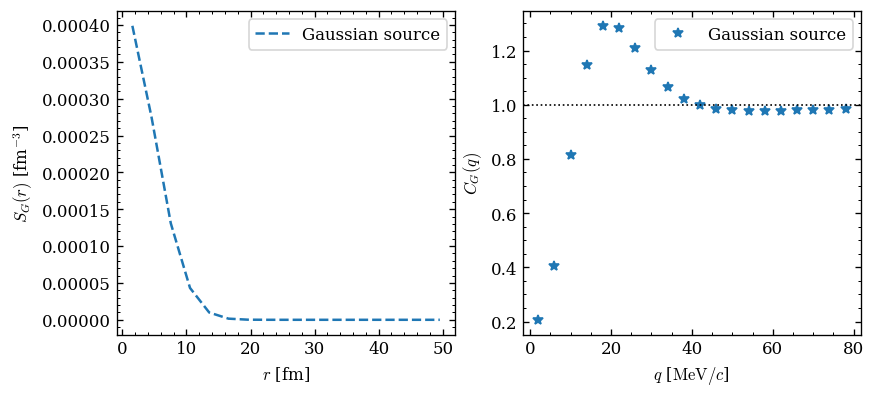

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

axes[0].plot(r, SG_true, label='Gaussian source', ls='--')
axes[1].plot(q, CG_true, label='Gaussian source', ls='none', marker='*') 

axes[1].axhline(1, color='k', ls=':', lw=1)

for ax in axes:
    ax.legend()

axes[0].set_xlabel(r'$r$ [fm]')
axes[0].set_ylabel(r'$S_G(r)$ [fm$^{-3}$]')
axes[1].set_xlabel(r'$q$ [$\mathrm{MeV}/c$]')
axes[1].set_ylabel(r'$C_G(q)$')

## start deblurring
-----------------------
- an uniform source function is used as initial guess
- $\lambda_{\mathrm{guess}} = \lambda_{\mathrm{true}}$, in practice we try different $\lambda_{mathrm{guess}}$ and optimize it by minimizing $\chi^2$ of data correlation.

In [12]:
def richardson_lucy_std(niter, X, y, psf, accel=1.99, return_all=False):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12

    X_preds = []
    y_preds = []

    for _ in range(niter):
        deconv = deconv * (np.einsum('i,ij', img / conv, psf_)) ** accel
        conv = np.dot(psf_, deconv) + 1e-12

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)

    if return_all:
        return X_preds, y_preds
    
    return X_preds[-1], y_preds[-1]

In [13]:
def uniform_source(r, lambda_):
    s = np.ones_like(r)
    norm = 4 * np.pi * np.trapz(s * r**2, r)
    return lambda_ * s / norm
    
lambda_guess = lambda_true
unif_guess = uniform_source(r, lambda_guess)
K = 4 * np.pi * (kernel + 1./ lambda_guess) * r ** 2 * dr

In [14]:
restored_list_gaus, predicted_list_gaus = richardson_lucy_std(
    niter = 1200000, 
    X = unif_guess,
    y = CG_true, 
    psf = K, 
    return_all = True
)

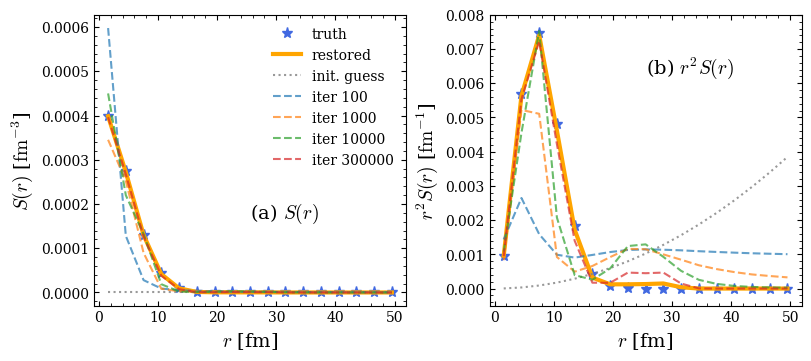

In [15]:
fig, axes = plt.subplots(1,2,figsize=(8,3.5), constrained_layout=True, dpi=100)

axes[0].plot(r, SG_true, label='truth', marker='*', ls='none', ms=8, color='royalblue')
axes[0].plot(r, restored_list_gaus[-1], label='restored', ls='-', lw=3, color='orange')
axes[1].plot(r, SG_true * r**2, label='truth', marker='*', ls='none', ms=8, color='royalblue')
axes[1].plot(r, restored_list_gaus[-1] * r**2, label='restored', ls='-', lw=3, color='orange')
axes[0].plot(r, unif_guess , label='init. guess', ls=':', color='gray', alpha=0.8)
axes[1].plot(r, unif_guess * r**2, label='inti. guess', ls=':', color='gray', alpha=0.8)

for i, epoch in enumerate([100, 1000, 10000, 300000]):
    axes[0].plot(r, restored_list_gaus[epoch - 1], ls='--', label=f'iter {int(epoch)}', alpha=0.7)
    axes[1].plot(r, restored_list_gaus[epoch - 1] * r**2, ls='--', label=f'iter {int(epoch)}', alpha=0.7)


axes[0].legend(loc='upper right', fontsize=10, ncols=1, handlelength=2, columnspacing=1, frameon=False)
axes[1].set_ylim(-0.0005, 0.008)

axes[0].annotate(
    r'(a) $S(r)$',
    xy=(0.5, 0.3),
    xycoords='axes fraction',
    fontsize=14,
)

axes[1].annotate(
    r'(b) $r^2S(r)$',
    xy=(0.5, 0.8),
    xycoords='axes fraction',
    fontsize=14,
)

axes[0].set_xlabel(r'$r$ [fm]', fontsize=14)
axes[1].set_xlabel(r'$r$ [fm]', fontsize=14)
axes[0].set_ylabel(r'$S(r)$ [$\mathrm{fm}^{-3}$]', fontsize=14)
axes[1].set_ylabel(r'$r^2S(r)$ [$\mathrm{fm}^{-1}$]', fontsize=14)
plt.show()